# Decision Trees and SVM 

## Introduction

The goal is to predict if a credit card transaction is fraudulent or not. We use the dataset [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) from Kaggle. 

First, import the necessary libraries and download the dataset.

In [40]:
!pip install pandas==2.2.3
!pip install scikit-learn==1.6.0
!pip install matplotlib==3.9.3

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


To import the libraries that will be used in this lab, execute the cells below. 


In [41]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [42]:
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"

raw_data=pd.read_csv(url)
raw_data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Dataset Analysis

Each row in the dataset represents a credit card transaction. The objective is to train a model based on the variables (V1, V2, ..., V28) to predict the value of the Class variable. (Class = 1 for fraud and Class = 0 for normal transaction.)

First retrieve basic statistics about the target variable.

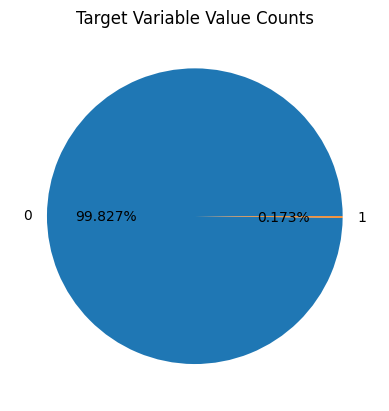

In [43]:
# The set of distinct classes
labels = raw_data.Class.unique()

# The count of each class
sizes = raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

The dataset is highly unbalanced, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at train time is to bias the model to pay more attention to the samples in the minority class. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.


We will prepare the data for training. 

1. $L^1$ normalization for the training models to converge quickly.
2. Drop the column "Time" and take features 2 to 30 as an input variable.
3. Class will be used as the target variable.

In [44]:
# scaling
raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(raw_data.iloc[:, 1:30])
data_matrix = raw_data.values

# input variables
X = data_matrix[:, 1:30]

# target variable
y = data_matrix[:, 30]

# normalizeation
X = normalize(X, norm="l1")

We split the dataset into the train set and the test set.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Decision Tree Classifier model

### Build a model

We train the Decision Tree classifier. 

In [46]:
dt = DecisionTreeClassifier(max_depth=4, random_state=35)
w_train = compute_sample_weight('balanced', y_train)
dt.fit(X_train, y_train, sample_weight=w_train)

DecisionTreeClassifier(max_depth=4, random_state=35)

In [47]:
y_pred_dt = dt.predict_proba(X_test)[:,1]

We evaluate the Area Under the Receiver Operating Characteristic Curve (ROC-AUC) score.

In [48]:
roc_auc_dt = roc_auc_score(y_test, y_pred_dt)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt))

Decision Tree ROC-AUC score : 0.939


## Support Vector Machine model (SVM)

### Build a model

In [49]:
svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False)
svm.fit(X_train, y_train)

LinearSVC(class_weight='balanced', fit_intercept=False, loss='hinge',
          random_state=31)

### Evaluation

In [50]:
y_pred_svm = svm.decision_function(X_test)

You may now evaluate the accuracy of SVM on the test set in terms of the ROC-AUC score.


In [51]:
roc_auc_svm = roc_auc_score(y_test, y_pred_svm)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm))

SVM ROC-AUC score: 0.986


## Variable Reduction

<Axes: >

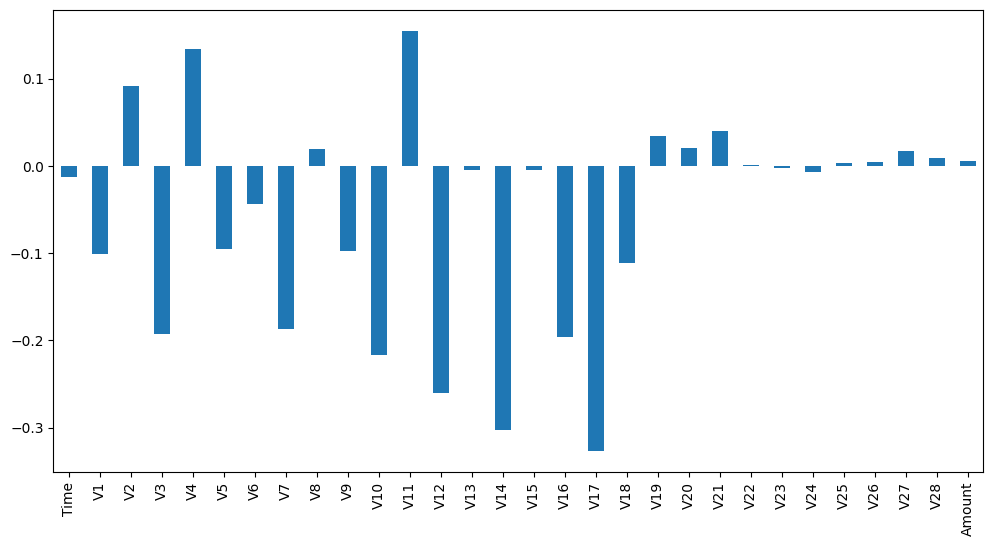

In [52]:
correlation_values = raw_data.corr()['Class'].drop('Class')
correlation_values.plot(kind='bar', figsize=(12, 6))

This clearly shows that some features affect the output Class more than the others. For efficient modeling, we may use only the most correlated features.

We choose the top 7 features. 

In [53]:
# your code goes here
correlation_values = abs(raw_data.corr()['Class']).drop('Class')
correlation_values = correlation_values.sort_values(ascending=False)[:7]
correlation_values

V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
V7     0.187257
Name: Class, dtype: float64

Using these 7 features, we train the SVM model as above and evaluate.

In [54]:
X_reduced = data_matrix[:,[3,7,10,12,14,16,17]]
X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

svm.fit(X_reduced_train, y_reduced_train)

y_pred_svm_reduced = svm.decision_function(X_reduced_test)
roc_auc_svm_reduced = roc_auc_score(y_test, y_pred_svm_reduced)
print("SVM ROC-AUC score: {0:.3f}".format(roc_auc_svm_reduced))


SVM ROC-AUC score: 0.969


We also apply the decision tree classifier with the reduced input data.

In [55]:
dt.fit(X_reduced_train, y_train, sample_weight=w_train)
y_pred_dt_reduced = dt.predict_proba(X_reduced_test)[:,1]
roc_auc_dt_reduced = roc_auc_score(y_test, y_pred_dt_reduced)
print('Decision Tree ROC-AUC score : {0:.3f}'.format(roc_auc_dt_reduced))

Decision Tree ROC-AUC score : 0.926


## Conclusion

- With a larger set of features, SVM performed relatively better in comparison to the Decision Trees.
- Decision Trees benefited from feature selection and performed better.
- SVMs may require higher feature dimensionality to create an efficient decision hyperplane.